In [1]:
import torch
import gudhi
import numpy as np
from math import exp
import matplotlib.pyplot as plt
from sftd import SFTDLossGudhi, plot_barcodes

In [2]:
def F(x):
    if abs(x) >= 1.:
        return 0
    else:
        z = np.abs(x**2)
        return 50 * np.exp(-1.0 / ((0.5 - z/2)* (z/2 + 0.5)))

In [3]:
def add_sphere(G, m1, m2, m3, rv):
    m1 = m2 = m3 = 0.5

    for i1 in range(32):
        for i2 in range(32):
            for i3 in range(32):
                r = pow((i1/32. - m1)**2 + (i2/32. - m2)**2 + (i3/32. - m3)**2, 0.5)
                G[i1, i2, i3] += -F(30 * abs(r - rv))
                
                if G[i1, i2, i3] < -0.01:
                    G[i1, i2, i3] = -1

In [4]:
def plot_3D(G1, G1_highlight = None, G_markers = None):
    fig = plt.figure(figsize=(25, 25))
    ax = fig.add_subplot(projection='3d')

    n = 100

    xs = []
    ys = []
    zs = []
    cs = []
    ss = []

    for i1 in range(32):
        for i2 in range(32):
            for i3 in range(32):

                xs.append(i1/32)
                ys.append(i2/32)
                zs.append(i3/32)
                
                size = min(20, 1 + 20 * abs(G1[i1, i2, i3]))
                
                if not (G1_highlight is None) and G1_highlight[i1, i2, i3] == 1:
                    cs.append(-0.5)
                    ss.append(100)
                else:
                    cs.append(G1[i1, i2, i3])
                    ss.append(size)

    ax.scatter(xs, ys, zs, marker='o', c = cs, s = ss, cmap = 'jet')

    #ax.set_xlabel('X Label')
    #ax.set_ylabel('Y Label')
    #ax.set_zlabel('Z Label')

    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    ax.get_zaxis().set_ticks([])
    #ax.set_xticklabels([])
    #ax.get_xaxis().set_visible(False)
    
    #plt.xlabel('')
    
    #plt.axis('off')
    #plt.tight_layout()

    #fig.subplots_adjust(left=-0.5, right=1, bottom=0, top=1)
    
    #plt.show()

### First object

In [5]:
G1 = torch.zeros((32, 32, 32))
G1_highlight = torch.zeros((32, 32, 32))

add_sphere(G1, 0.5, 0.5, 0.5, 0.4)
add_sphere(G1, 0.5, 0.5, 0.5, 0.2)

for i1 in range(15, 18):
    for i2 in range(15, 18):
        for i3 in range(24, 30):
            
            G1_highlight[i1, i2, i3] = 1
            G1[i1, i2, i3] = -1

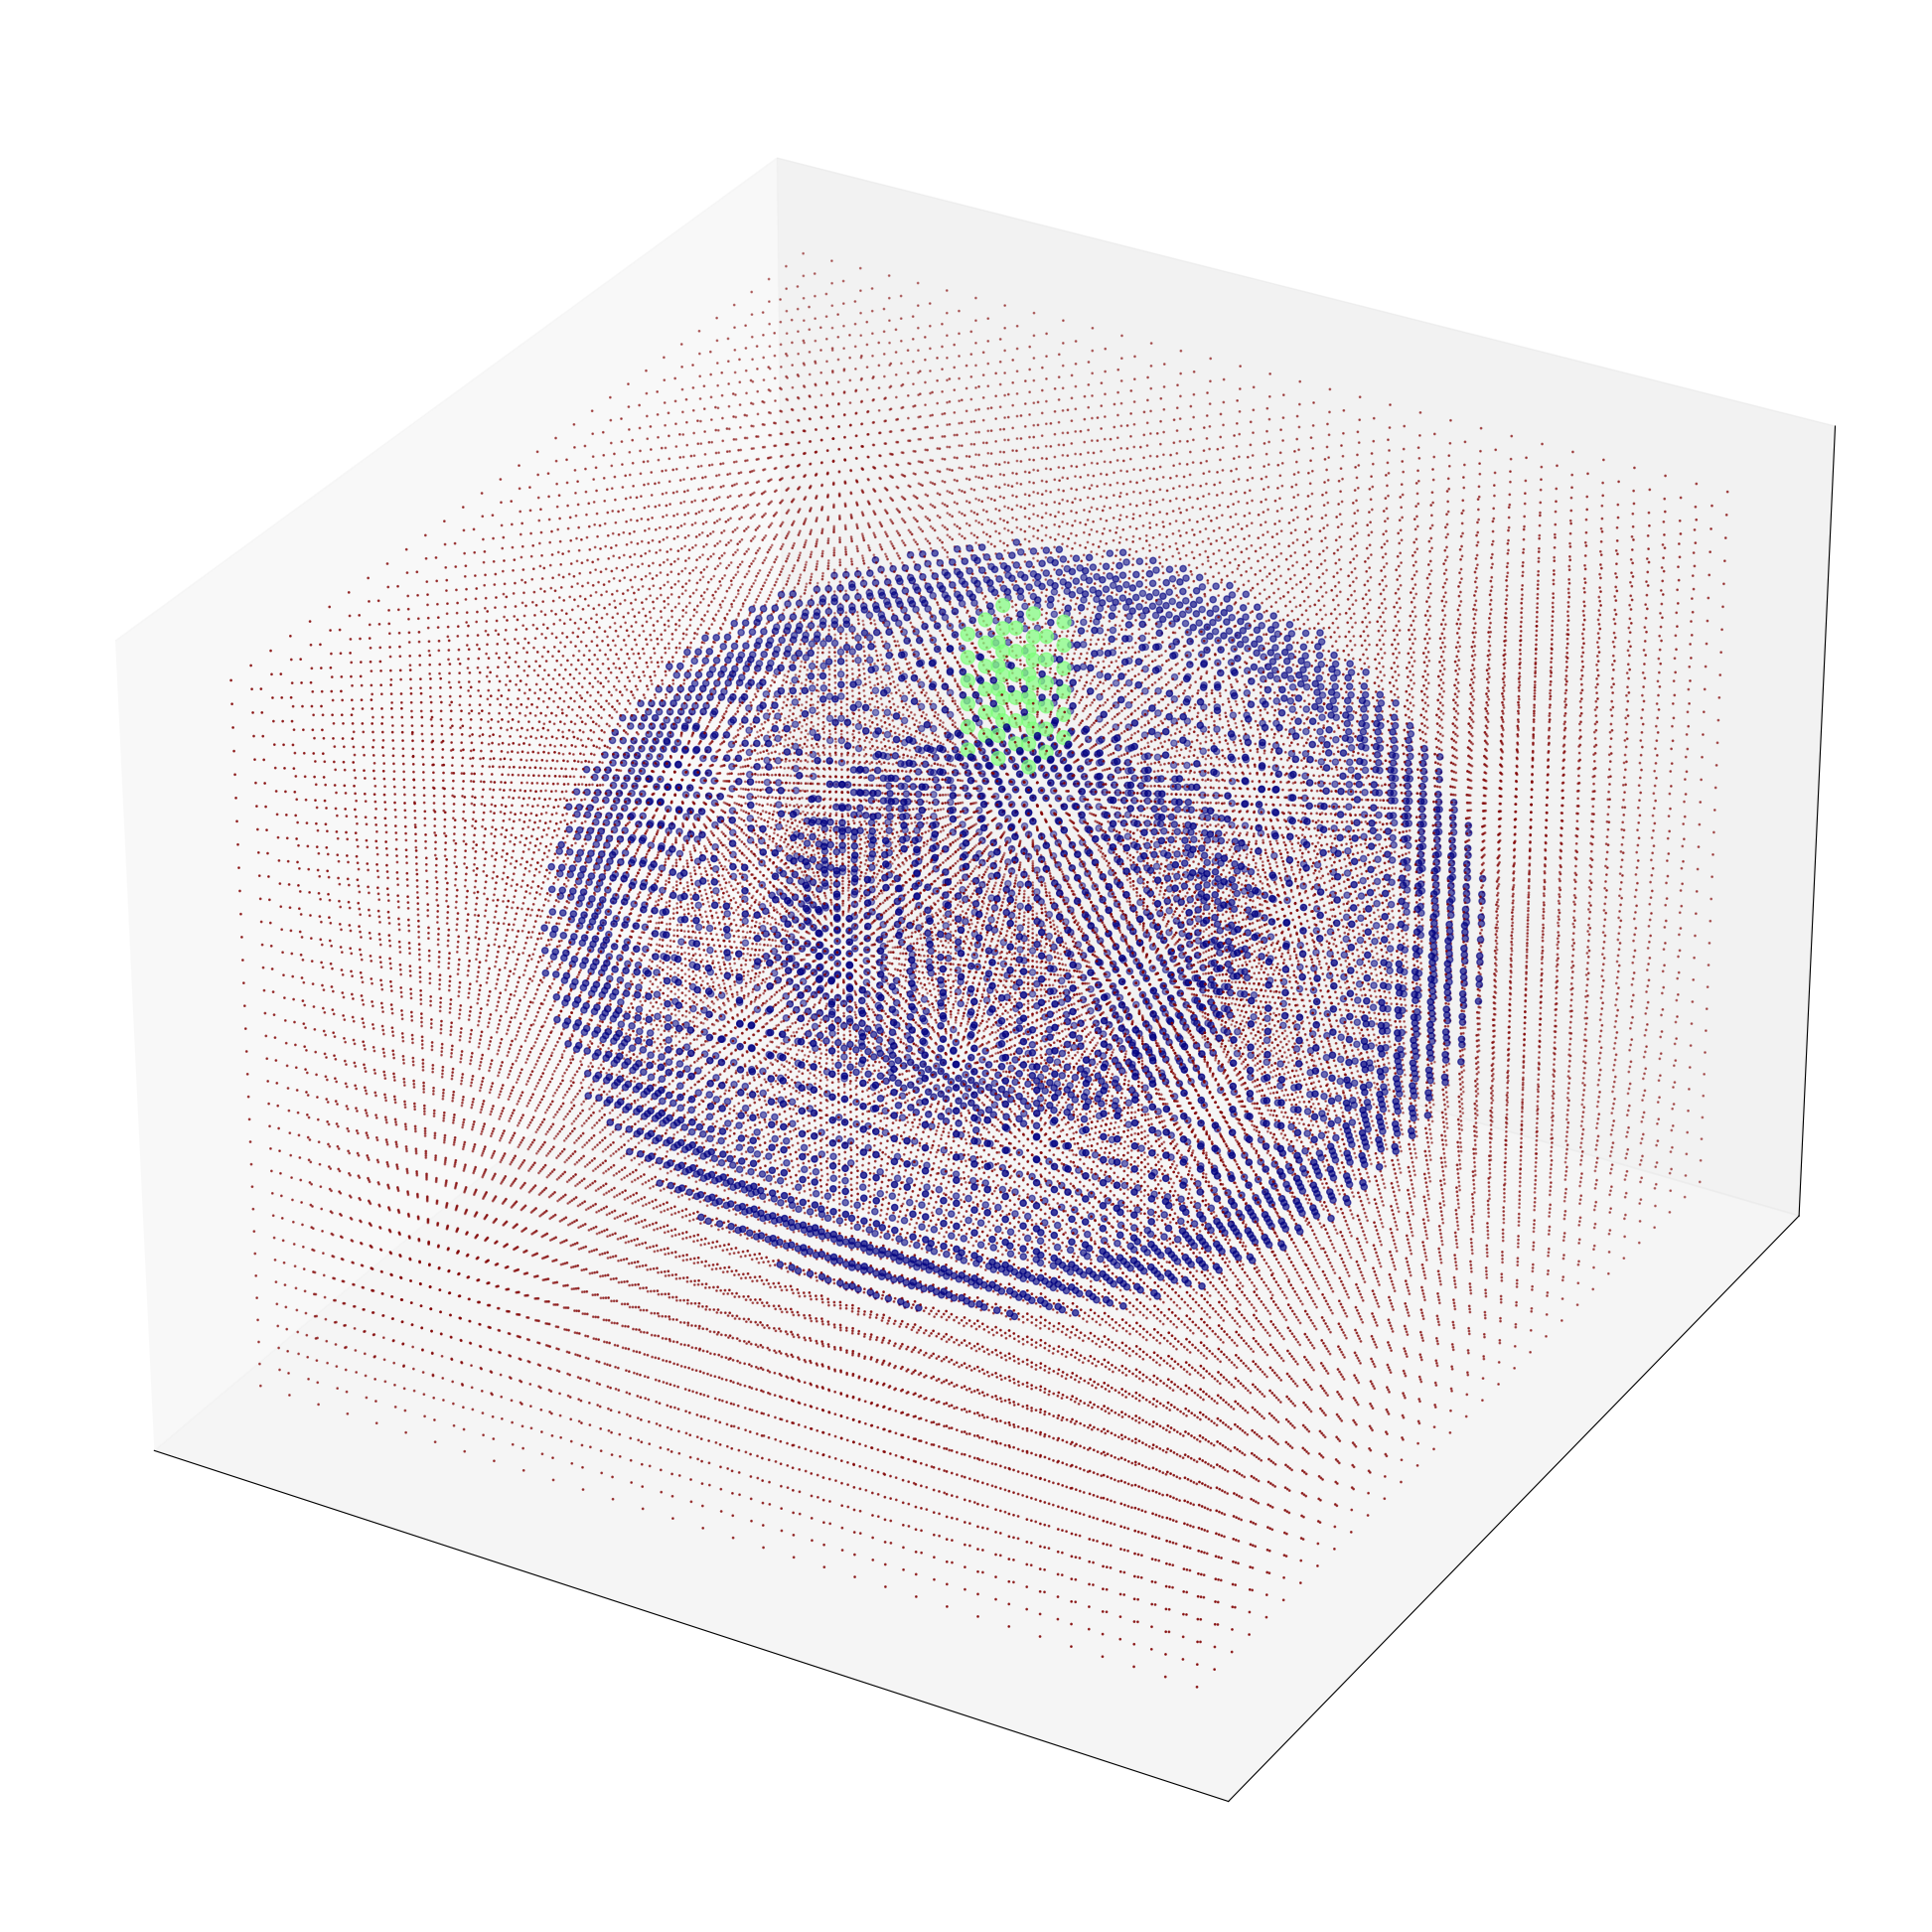

In [6]:
plot_3D(G1, G1_highlight)

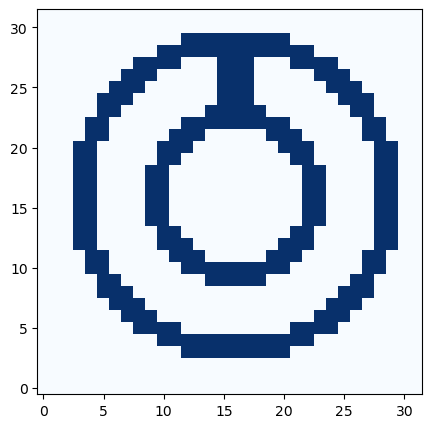

In [7]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(5, 5))

ax.imshow(G1[16, :, :].T.numpy(), cmap = 'Blues_r', origin = 'lower')
#plt.colorbar()

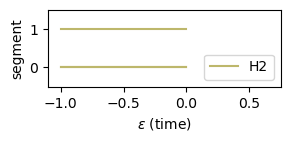

In [8]:
cubical_complex = gudhi.CubicalComplex(vertices = G1.numpy())
cubical_complex.compute_persistence(homology_coeff_field = 2, min_persistence = 0.0)
barc0 = cubical_complex.persistence_intervals_in_dimension(0)[0:-1,]
barc1 = cubical_complex.persistence_intervals_in_dimension(1)
barc2 = cubical_complex.persistence_intervals_in_dimension(2)

fig, ax = plt.subplots(1, 1)
fig.set_size_inches((3, 1))

ax.set_ylim(-0.5, 1.5)
ax.set_xlim(-1.1, 0.75)

plot_barcodes([barc0, barc1, barc2])

### Second figure

In [9]:
G2 = torch.zeros((32, 32, 32))
G2_highlight = torch.zeros((32, 32, 32))

add_sphere(G2, 0.5, 0.5, 0.5, 0.4)
add_sphere(G2, 0.5, 0.5, 0.5, 0.2) 

In [10]:
for i1 in range(15, 18):
    for i2 in range(15, 18):
        for i3 in range(4, 9):
            
            G2_highlight[i1, i2, i3] = 1
            G2[i1, i2, i3] = -1

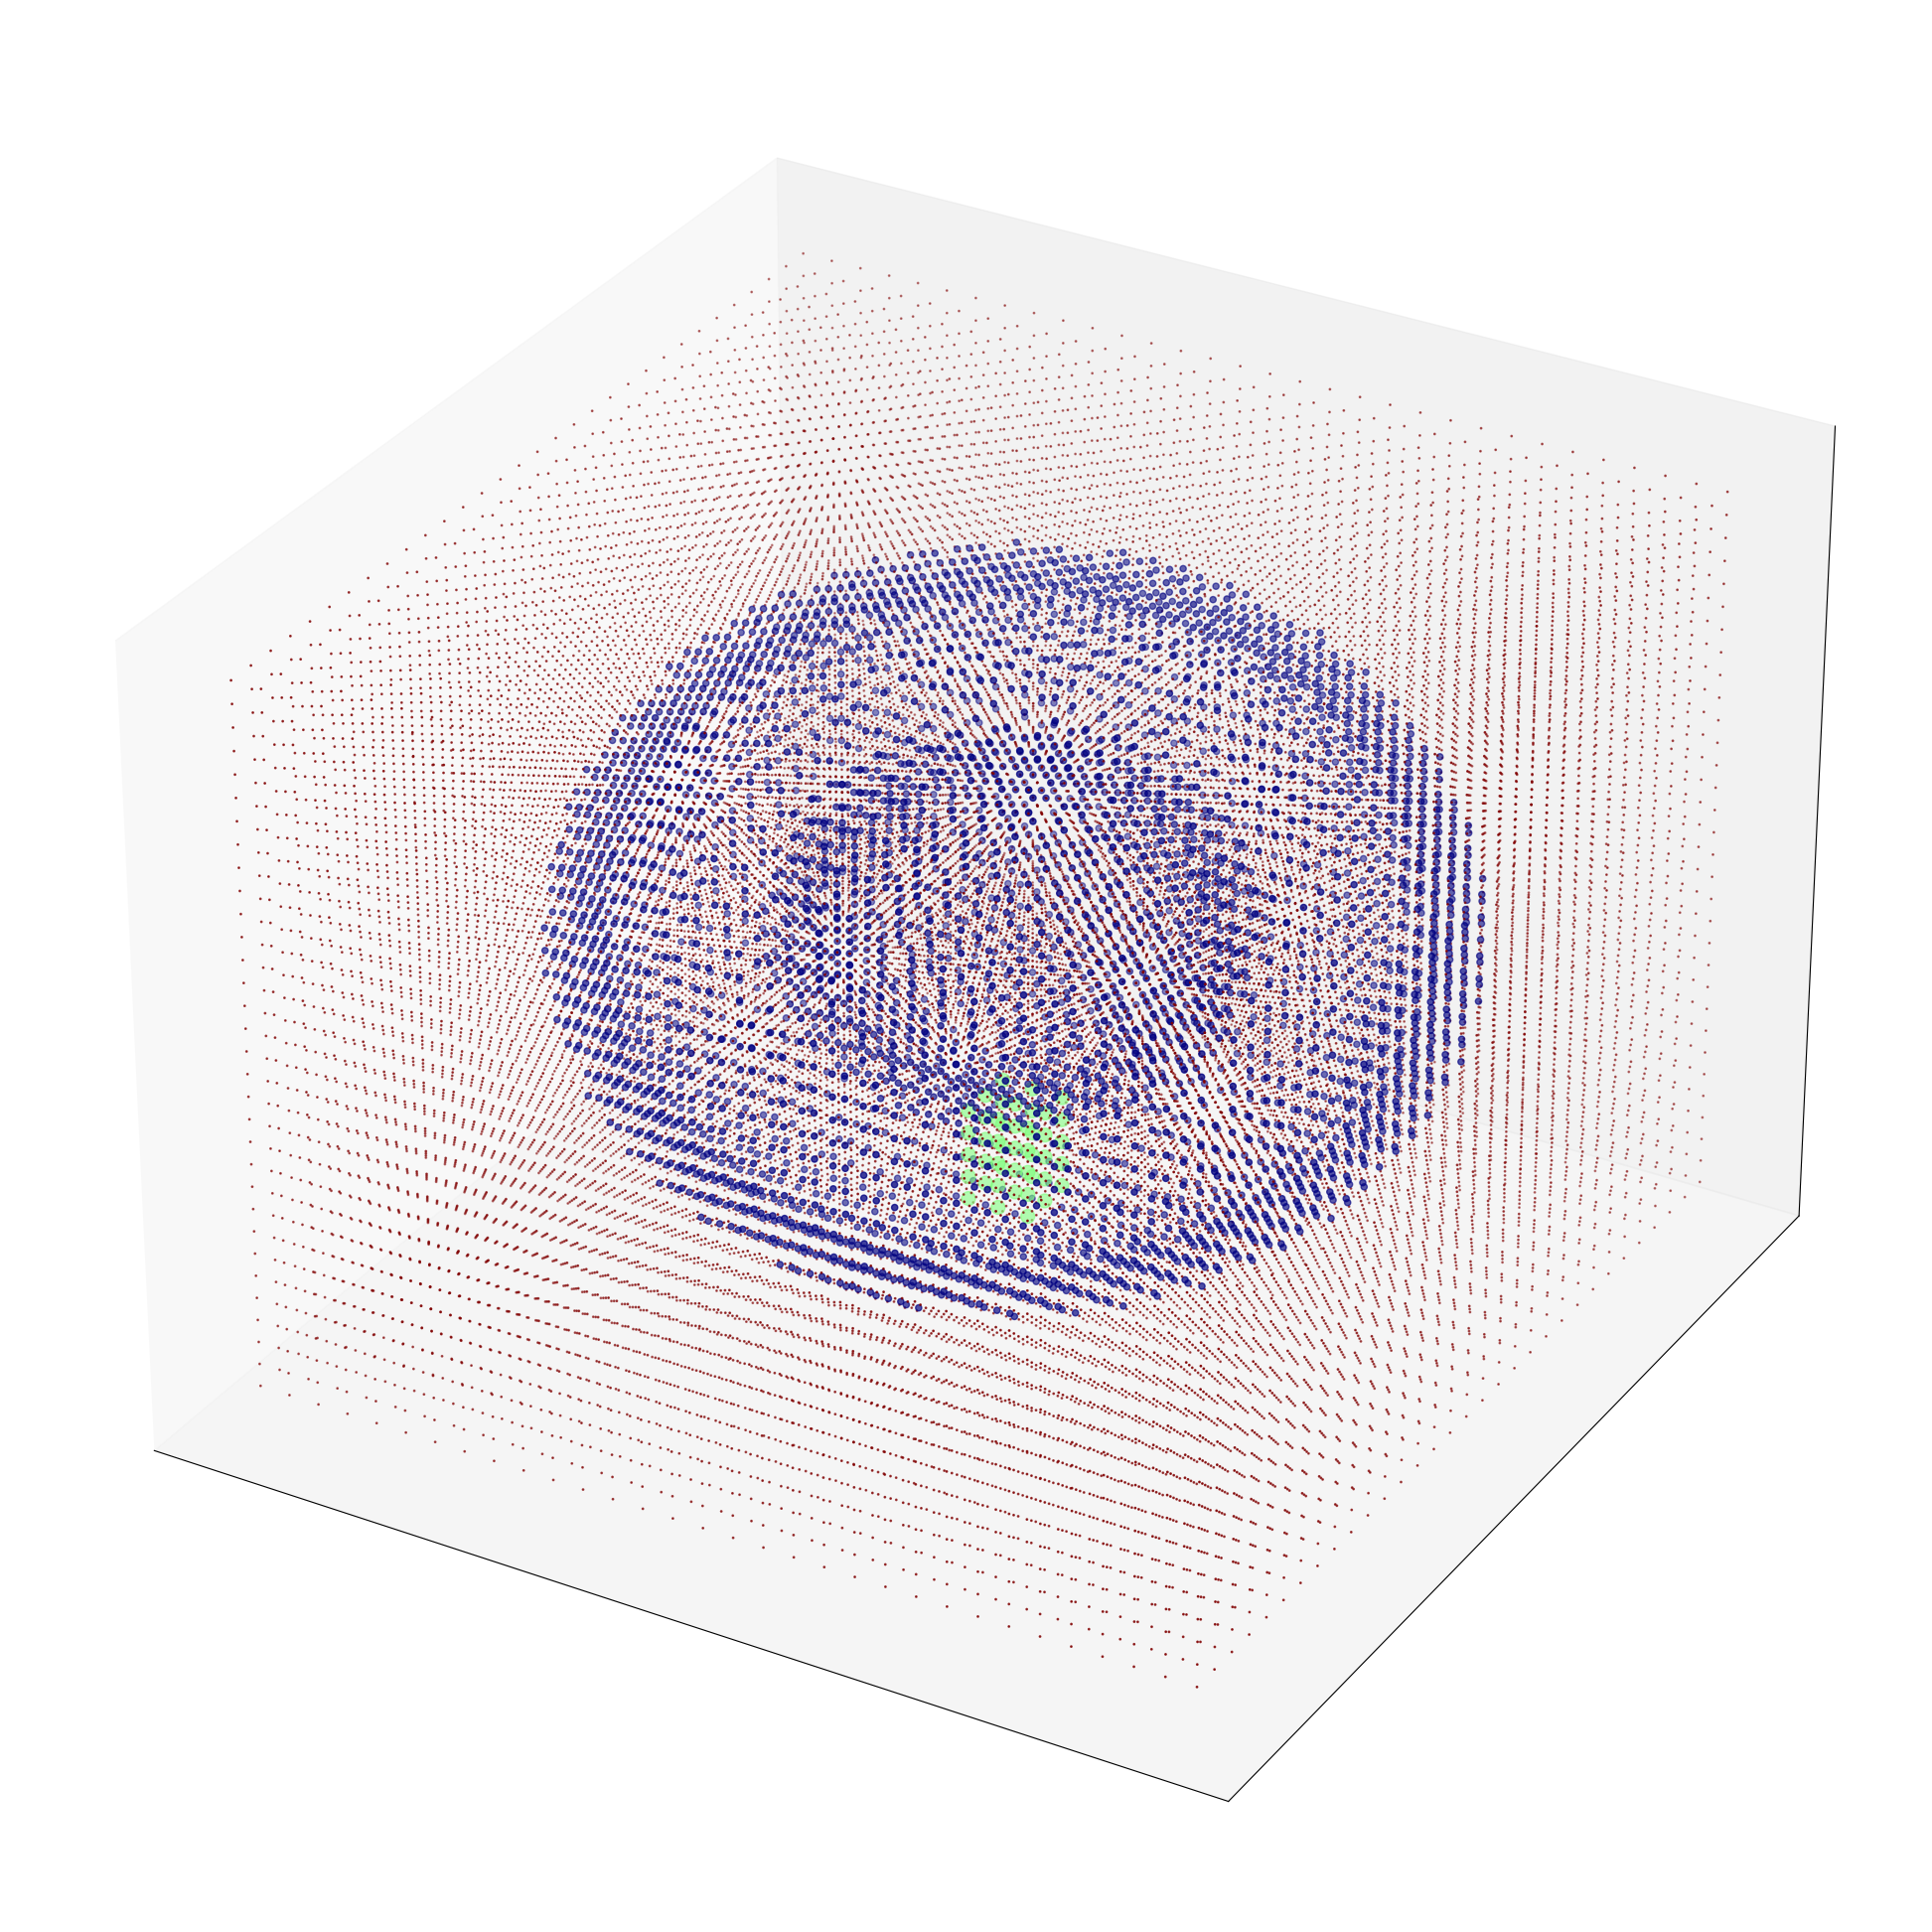

In [11]:
plot_3D(G2, G2_highlight)

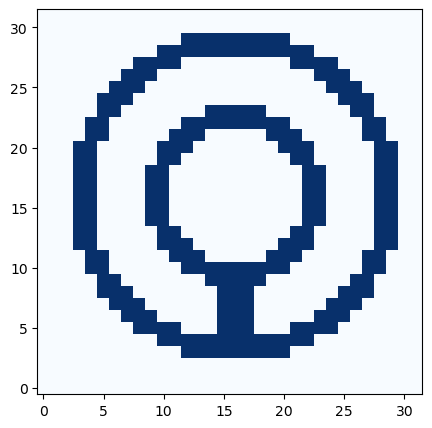

In [12]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(5, 5))

ax.imshow(G2[16,:, :].T.numpy(), cmap = 'Blues_r', origin = 'lower')
#plt.colorbar()

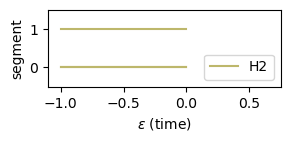

In [13]:
cubical_complex = gudhi.CubicalComplex(vertices = G2.numpy())
cubical_complex.compute_persistence(homology_coeff_field = 2, min_persistence = 0.0)
barc0 = cubical_complex.persistence_intervals_in_dimension(0)[0:-1,]
barc1 = cubical_complex.persistence_intervals_in_dimension(1)
barc2 = cubical_complex.persistence_intervals_in_dimension(2)

fig, ax = plt.subplots(1, 1)
fig.set_size_inches((3, 1))

ax.set_ylim(-0.5, 1.5)
ax.set_xlim(-1.1, 0.75)

plot_barcodes([barc0, barc1, barc2])

### Evaluate SFD

In [14]:
sfd = SFTDLossGudhi(dims = [0, 1, 2, 3])

In [15]:
sfd(G1, G2)
pers0 = sfd.cubical_complex.persistence_intervals_in_dimension(0)[1:]
pers1 = sfd.cubical_complex.persistence_intervals_in_dimension(1)

In [16]:
for dim in [0, 1, 2, 3]:
    print(dim, sfd.cubical_complex.persistence_intervals_in_dimension(dim))

0 [[-1. inf]]
1 [[-1.  0.]]
2 []
3 []


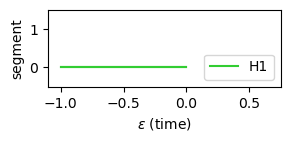

In [17]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches((3, 1))

ax.set_ylim(-0.5, 1.5)
ax.set_xlim(-1.1, 0.75)

plot_barcodes(np.array([pers0, pers1], dtype = object))

In [18]:
sfd(G2, G1)
pers0 = sfd.cubical_complex.persistence_intervals_in_dimension(0)
pers1 = sfd.cubical_complex.persistence_intervals_in_dimension(1)

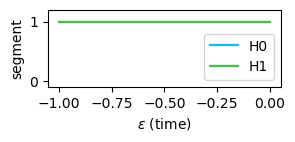

In [19]:
fig, ax = plt.subplots(1, 1)
ax.set_ylim(-0.1, 1.2)
#ax.set_xlim(-1.1, 1.75)
fig.set_size_inches((3, 1))

plot_barcodes(np.array([pers0, pers1]))

In [20]:
sfd.D.shape

torch.Size([3, 32, 32, 32])

In [21]:
def get_elem(D_shape, num):
    
    num_orig = num
    
    i1 = num // (D_shape[0] * D_shape[1] * D_shape[2])
    num -= i1 * (D_shape[0] * D_shape[1] * D_shape[2])
    
    i2 = num // (D_shape[0] * D_shape[1])
    num -= i2 * (D_shape[0] * D_shape[1])
    
    i3 = num // D_shape[0]
    num -= i3 * D_shape[0]
    
    i4 = num

    return i4, i3, i2, i1

In [22]:
dim = 1
    
for idx, (v1, v2) in enumerate(sfd.v[0][dim]):
        print('dim', dim, v1, v2, get_elem(sfd.D.shape, v1), get_elem(sfd.D.shape, v2))

        markers = ['o', 'x', '*', 's', 'p']
        i1, i2, i3, i4 = get_elem(sfd.D.shape, v1)
        j1, j2, j3, j4 = get_elem(sfd.D.shape, v2)

dim 1 87405 84333 (0, 15, 14, 28) (0, 15, 14, 27)


In [23]:
G_marker = torch.zeros((32, 32, 32))

In [24]:
def add_markers(G_marker, dim = 1):
    
    for idx, (v1, v2) in enumerate(sfd.v[0][dim]):
            print('dim', dim, v1, v2, get_elem(sfd.D.shape, v1), get_elem(sfd.D.shape, v2))

            markers = ['o', 'x', '*', 's', 'p']
            i1, i2, i3, i4 = get_elem(sfd.D.shape, v1)
            j1, j2, j3, j4 = get_elem(sfd.D.shape, v2)
            
            G_marker[i2, i3, i4] = 1
            G_marker[j2, j3, j4] = 1
            
            ax.plot(i3, i4, 'o', color = 'red', markersize = 7)
            ax.plot(j3, j4, 'o', color = 'orange', markersize = 7)

In [25]:
sfd(G1, G2)
add_markers(G_marker)

sfd(G2, G1)
add_markers(G_marker)

dim 1 29040 25965 (0, 16, 14, 9) (0, 15, 14, 8)
dim 1 87405 84333 (0, 15, 14, 28) (0, 15, 14, 27)


dim 1 29040 25965 (0, 16, 14, 9) (0, 15, 14, 8)
dim 1 87405 84333 (0, 15, 14, 28) (0, 15, 14, 27)


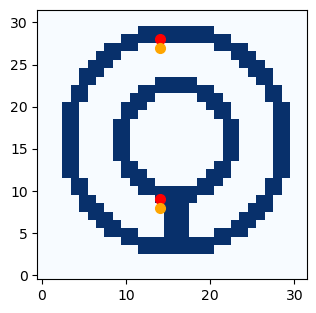

In [28]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(3.5, 3.5))

ax.imshow(G2[16,:, :].T, cmap = 'Blues_r', origin = 'lower')

sfd(G1, G2)
add_markers(G_marker)

sfd(G2, G1)
add_markers(G_marker)